In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def show_10_images(data):    
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(data[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from keras.regularizers import l1
from keras.models import Model

n_hidden = 256
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Flatten()(x)
encoded = Dense(n_hidden, activity_regularizer=l1(10e-8))(x)

# representation is now size n_hidden

x = Dense(7*7*32)(encoded)
x = Reshape((7, 7, 32))(x)

x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [3]:
import os

weight_file = './weights/mnist_autoencoder_all_digits_binary_crossentropy_noise.hd5'

if(os.path.exists(weight_file)):
    autoencoder.load_weights(weight_file)
else:
    autoencoder.fit(x_train_noisy, x_train,
                    epochs=100,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test),
                    callbacks=[])

    autoencoder.save_weights(weight_file)

In [4]:
from keras.layers import Lambda
from keras.losses import binary_crossentropy
import keras.backend as K 

input_ = Input(shape=(28, 28, 1))
predicted = autoencoder(input_)
loss = Lambda(lambda x: binary_crossentropy(K.batch_flatten(input_), K.batch_flatten(x)))(predicted)

anomaly_detector = Model(input_, loss)

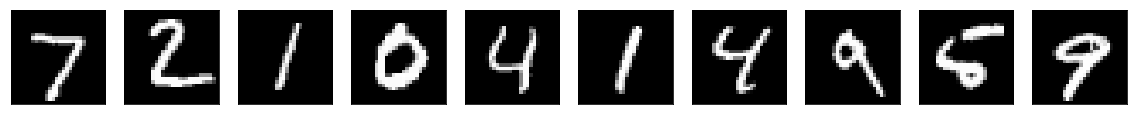

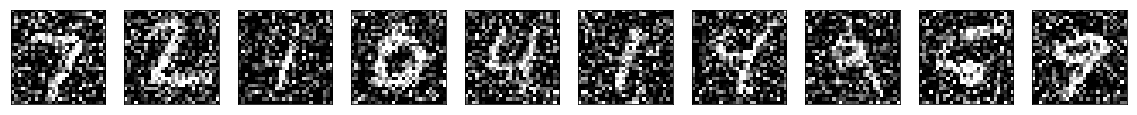

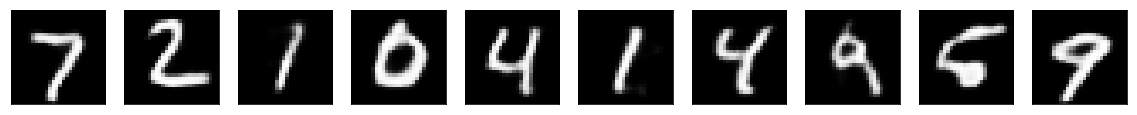

In [5]:
n = 10

# Ground truth
show_10_images(x_test)

#Images with noise added
show_10_images(x_test_noisy)

# Denoised images
show_10_images(autoencoder.predict(x_test_noisy))

# Ground truth with denoising
# show_10_images(autoencoder.predict(x_test)

## Fashion MNIST

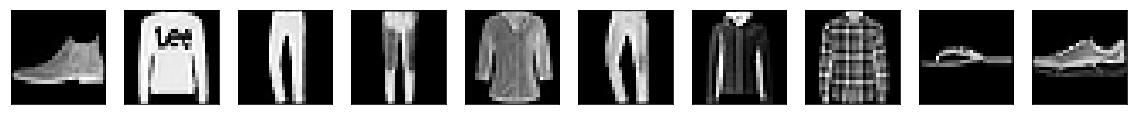

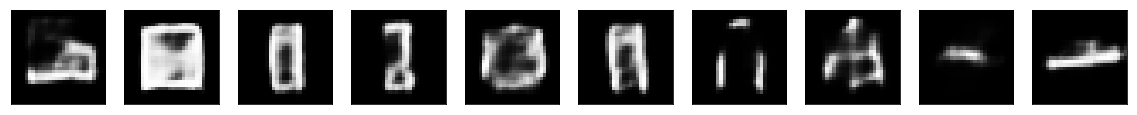

In [6]:
from keras.datasets import fashion_mnist
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

_, (fashion_x_test, _) = fashion_mnist.load_data()

fashion_x_test = fashion_x_test.astype('float32') / 255.
fashion_x_test = np.reshape(fashion_x_test, (len(x_test), 28, 28, 1))

show_10_images(fashion_x_test)
show_10_images(autoencoder.predict(fashion_x_test))

In [7]:
labels = len(x_test) * [0] + len(fashion_x_test) * [1]
test_samples = np.concatenate((x_test, fashion_x_test))
losses = anomaly_detector.predict(test_samples)
print("AUROC:", roc_auc_score(labels, losses))

AUROC: 0.9999329299999999


## EMNIST Letters

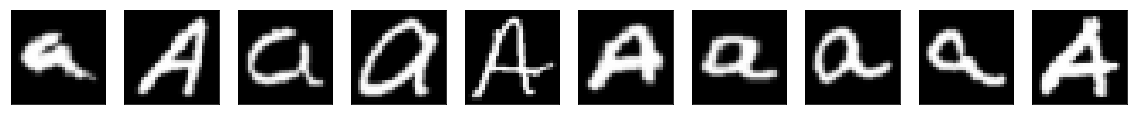

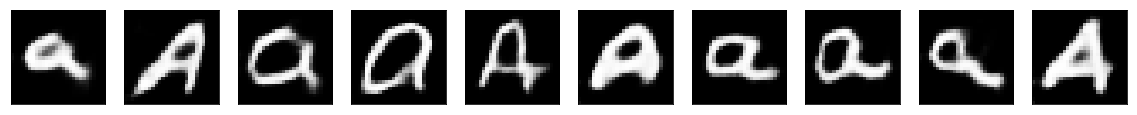

In [8]:
from torchvision.datasets import EMNIST

emnist_letters = EMNIST('./', "letters", train=False, download=True)
emnist_letters = emnist_letters.test_data.numpy()
emnist_letters = emnist_letters.astype('float32') / 255.
emnist_letters = np.swapaxes(emnist_letters, 1, 2)

emnist_letters = np.reshape(emnist_letters, (len(emnist_letters), 28, 28, 1))

show_10_images(emnist_letters)
show_10_images(autoencoder.predict(emnist_letters))

In [9]:
labels = len(x_test) * [0] + len(emnist_letters) * [1]
test_samples = np.concatenate((x_test, emnist_letters))
losses = anomaly_detector.predict(test_samples)
print("AUROC:", roc_auc_score(labels, losses))

AUROC: 0.9373014615384615


## Gaussian Noise

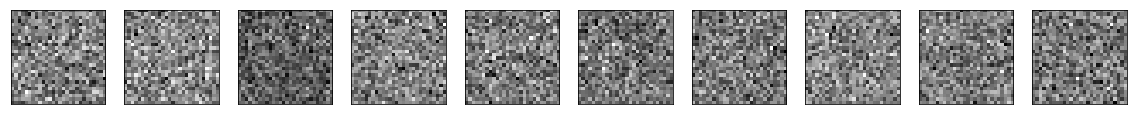

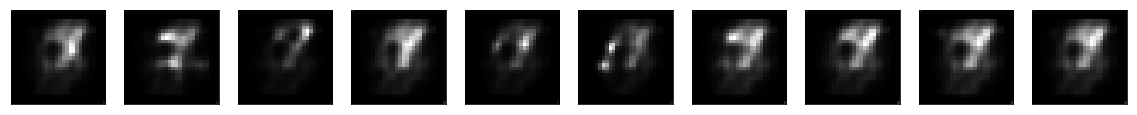

In [10]:
mnist_mean = np.mean(x_train)
mnist_std = np.std(x_train)
gaussian_data = np.random.normal(mnist_mean, mnist_std, size=(10000, 28, 28, 1))

show_10_images(gaussian_data)
show_10_images(autoencoder.predict(gaussian_data))

In [11]:
labels = len(x_test) * [0] + len(gaussian_data) * [1]
test_samples = np.concatenate((x_test, gaussian_data))
losses = anomaly_detector.predict(test_samples)
print("AUROC:", roc_auc_score(labels, losses))

AUROC: 1.0


## Uniform Noise

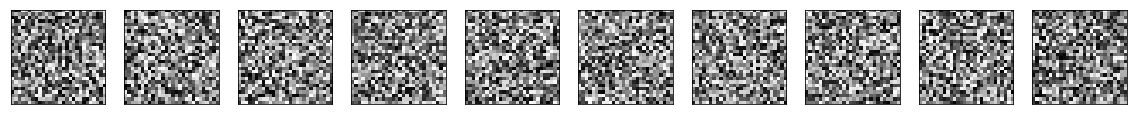

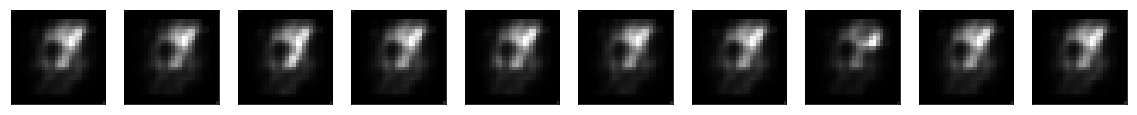

In [12]:
import math
b = math.sqrt(3.) * mnist_std
a = -b + mnist_mean
b += mnist_mean

uniform_data = np.random.uniform(low=a, high=b, size=(10000, 28, 28, 1))

show_10_images(uniform_data)
show_10_images(autoencoder.predict(uniform_data))

In [13]:
labels = len(x_test) * [0] + len(uniform_data) * [1]
test_samples = np.concatenate((x_test, uniform_data))
losses = anomaly_detector.predict(test_samples)
print("AUROC:", roc_auc_score(labels, losses))

AUROC: 1.0
